In [17]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import category_encoders
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Below is balanced version of accuracy that shows the accuracy with class weights as in test. It helps to get highly correlated results between validation and test data; 

In [2]:
def bal_acc(y_true,y_pred,weights=None):
    #weights should be provided as list of weights for each class to sum up to 1
    temp1=np.unique(y_true,return_counts=True)[1]
    temp2=confusion_matrix(y_true,y_pred)
    acc_bal=np.sum(np.diag(temp2)*(temp1/np.sum(temp1))/temp1)
    if len(weights)==0:
        acc_weig=acc_bal
    elif len(weights)!=len(temp1):
        print('provide weight for each class')
    else:
        acc_weig=np.sum(np.diag(temp2)*weights/temp1)
    return (acc_weig,acc_bal)

### Load the Data

In [3]:
train=pd.read_csv(os.path.join(os.getcwd(),'train.csv.zip'))

In [4]:
#class_weights={1: 0.37062, 2: 0.49657,3:0.05947,4:0.018,5:0.018,6:0.018,7:0.018}
#found by probing weights of each class in test
class_weights={1: 0.37053, 2: 0.49657,3:0.05947,4:0.00106,5:0.01287,6:0.02698,7:0.03238}
list_weight=compute_class_weight(class_weights,np.unique(train['Cover_Type']),train['Cover_Type'])

In [5]:
#one more time but this version will be needed for cross validation
from sklearn.metrics import make_scorer
def bal_acc2(y_true,y_pred):
    #weights should be provided as list of weights for each class to sum up to 1
    temp1=np.unique(y_true,return_counts=True)[1]
    temp2=confusion_matrix(y_true,y_pred)
    acc_bal=np.sum(np.diag(temp2)*(temp1/np.sum(temp1))/temp1)
    weights=[0.37053, 0.49657, 0.05947, 0.00106, 0.01287, 0.02698, 0.03238]
    acc_weig=np.sum(np.diag(temp2)*weights/temp1)
    return (acc_weig)

my_score = make_scorer(bal_acc2)

In [6]:
#columns
target_col='Cover_Type'
soil_type=[x for x in train.columns if 'Soil' in x]
wild_type=[x for x in train.columns if 'Wilderness' in x]
vert_dist=['Vertical_Distance_To_Hydrology']
hor_dist=['Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',  'Horizontal_Distance_To_Fire_Points']
hill_feat=['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']
other_feat=['Elevation', 'Aspect', 'Slope']

Below are names of soil types as I use them for features extraction; 

NOTE I changed Cryaquolis to Cryaquolls

In [7]:
soil_names = {
0: 'Cathedral family - Rock outcrop complex, extremely stony.',
1: 'Vanet - Ratake families complex, very stony.',
2: 'Haploborolis - Rock outcrop complex, rubbly.',
3: 'Ratake family - Rock outcrop complex, rubbly.',
4: 'Vanet family - Rock outcrop complex complex, rubbly.',
5: 'Vanet - Wetmore families - Rock outcrop complex, stony.',
6: 'Gothic family.',
7: 'Supervisor - Limber families complex.',
8: 'Troutville family, very stony.',
9: 'Bullwark - Catamount families - Rock outcrop complex, rubbly.',
10: 'Bullwark - Catamount families - Rock land complex, rubbly.',
11: 'Legault family - Rock land complex, stony.',
12: 'Catamount family - Rock land - Bullwark family complex, rubbly.',
13: 'Pachic Argiborolis - Aquolis complex.',
14: 'unspecified in the USFS Soil and ELU Survey.',
15: 'Cryaquolls - Cryoborolis complex.',
16: 'Gateview family - Cryaquolls complex.',
17: 'Rogert family, very stony.',
18: 'Typic Cryaquolls - Borohemists complex.',
19: 'Typic Cryaquepts - Typic Cryaquolls complex.',
20: 'Typic Cryaquolls - Leighcan family, till substratum complex.',
21: 'Leighcan family, tibbll substratum, extremely bouldery.',
22: 'Leighcan family, till substratum - Typic Cryaquolls complex.',
23: 'Leighcan family, extremely stony.',
24: 'Leighcan family, warm, extremely stony.',
25: 'Granile - Catamount families complex, very stony.',
26: 'Leighcan family, warm - Rock outcrop complex, extremely stony.',
27: 'Leighcan family - Rock outcrop complex, extremely stony.',
28: 'Como - Legault families complex, extremely stony.',
29: 'Como family - Rock land - Legault family complex, extremely stony.',
30: 'Leighcan - Catamount families complex, extremely stony.',
31: 'Catamount family - Rock outcrop - Leighcan family complex, extremely stony.',
32: 'Leighcan - Catamount families - Rock outcrop complex, extremely stony.',
33: 'Cryorthents - Rock land complex, extremely stony.',
34: 'Cryumbrepts - Rock outcrop - Cryaquepts complex.',
35: 'Bross family - Rock land - Cryumbrepts complex, extremely stony.',
36: 'Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.',
37: 'Leighcan - Moran families - Cryaquolls complex, extremely stony.',
38: 'Moran family - Cryorthents - Leighcan family complex, extremely stony.',
39: 'Moran family - Cryorthents - Rock land complex, extremely stony.',}

### Feature engineering

Here I add some features hoping to get better result; 

In [8]:
def add_cat(df,soil_type,wild_type,soil_names,hill_feat):
    #first add categories
    df['soil_cat']=np.dot(df[soil_type],np.arange(len(soil_type)).reshape((len(soil_type),1)))
    df['wild_cat']=np.dot(df[wild_type],np.arange(len(wild_type)).reshape((len(wild_type),1)))
    df['soil_wild_cat']=df['soil_cat']*10+df['wild_cat']
    #next add names
    df["soil_name"]=df['soil_cat'].map(soil_names)
    #add some text features
    #check how stony is the soil
    df['stone_cat']=0
    df['stone_cat']+=df["soil_name"].str.contains(', rubbly')*1
    df['stone_cat']+=df["soil_name"].str.contains(', stony')*2
    df['stone_cat']+=df["soil_name"].str.contains('very stony')*3
    df['stone_cat']+=df["soil_name"].str.contains('extremely stony')*4
    df['wild_stone']=df['stone_cat']*10+df['wild_cat']    
    #check if Rock is in name
    df['Rock_cat']=df["soil_name"].str.contains('Rock outcrop')*1+df["soil_name"].str.contains('Rock land')*2
    df['if_Leighcan']=df["soil_name"].str.contains('Leighcan')*1
    df['if_Cryaquolls']=df["soil_name"].str.contains('Cryaquolls')*1
    df['if_Catamount']=df["soil_name"].str.contains('Catamount')*1
    df['if_Cryorthents']=df["soil_name"].str.contains('Cryorthents')*1    
    #relative distances
    df['Hyd_2_Road']=df['Horizontal_Distance_To_Hydrology']/(df['Horizontal_Distance_To_Roadways']+df['Horizontal_Distance_To_Hydrology']+0.0001)
    df['Hyd_2_Fire']=df['Horizontal_Distance_To_Hydrology']/(df['Horizontal_Distance_To_Fire_Points']+df['Horizontal_Distance_To_Hydrology']+0.0001)
    df['Fire_2_Road']=df['Horizontal_Distance_To_Fire_Points']/(df['Horizontal_Distance_To_Roadways']+df['Horizontal_Distance_To_Fire_Points']+0.0001)
    #add average shade
    df['av_shade']=(df[hill_feat[0]]+df[hill_feat[1]]+df[hill_feat[2]])/3
    df['dif_shade']=(df[hill_feat[0]]-df[hill_feat[2]])
    #add sin of Aspect and slope
    df['Sin_Aspect'] = np.sin(np.radians(df['Aspect']))
    df['Sin_Slope'] = np.sin(np.radians(df['Slope']))
    df["world_side"]=np.logical_and(df['Aspect']>90,df['Aspect']<=180)*1+np.logical_and(df['Aspect']>180,df['Aspect']<=270)*2+np.logical_and(df['Aspect']>270,df['Aspect']<=360)*3
    #below water
    df['if_below']=(df['Vertical_Distance_To_Hydrology']<0)*1
    df['Vertical_Distance_To_Hydrology']=np.abs(df['Vertical_Distance_To_Hydrology'])
    #convert to sqrt
    
    return df

In [80]:
train_new=add_cat(train,soil_type,wild_type,soil_names,hill_feat)

In [81]:
#below are features to use for traning
learn_cols=['Elevation',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'soil_cat', 'wild_cat', 'stone_cat', 'Hyd_2_Road', 'Hyd_2_Fire', 'Fire_2_Road', 'av_shade',
       'Sin_Aspect', 'Sin_Slope','dif_shade',"world_side",'wild_stone','soil_wild_cat','if_below', 'Rock_cat', 'if_Leighcan',
       'if_Cryaquolls', 'if_Catamount', 'if_Cryorthents']

### Encoding

It is 2 stage encoding:
- we make 2 cross validations for the features to minimize leakage possibility;
- It is likelihood target encoding - we find likelihood of each category of feature for each target value;
- so first I split the data into 20 folds, 1 hold out and next 19 I also subsplit into 10 slpits where I calculate likelihoods in crossvalidation manner; Then I mean the cross validation results of 10 subsplits and use to predict encodings for fold that was taken;

http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html

pip install category_encoders

Its taking mean value of y. But not plain mean, but in cross-validation within cross-validation way;

Let's say we have 20-fold cross validation. we need somehow to calculate mean value of the feature for #1 fold using information from #2-#20 folds only.

So, you take #2-#20 folds, create another cross validation set within it (i did 10-fold). calculate means for every leave-one-out fold (in the end you get 10 means). You average these 10 means and apply that vector for your primary #1 validation set. Repeat that for remaining 19 folds.

It is tough to explain, hard to understand and to master :) But if done correctly it can bring many benefits:)

In [13]:
def full_enc_6(df,features,target_col,alpha,n_splits,encode_targets,df_test=None):
    #have some troubles with index so reset and save
    temp_index=df.index
    df=df.reset_index(drop=True)
    #find unique values for target
    #temp_target=df[target_col].unique()[:-1]
    temp_target=list(encode_targets)
    #make the names of new features
    temp_cols=['{}_enc_{}'.format(x, y) for x in features for y in temp_target]
    #make splits
    split_enc = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #make saving dataframe
    enc_save=pd.DataFrame(np.zeros([df.shape[0],len(temp_target)*len(features)]))
    enc_save.columns=temp_cols
    #make splits
    for enc_train_index, enc_test_index in split_enc.split(df[features],df[target_col]):
        df_train=df.iloc[enc_train_index,:]
        df_val=df.iloc[enc_test_index,:]
        #make one more saving
        enc_save_2=pd.DataFrame(np.zeros([df_val.shape[0],len(temp_target)*len(features)]))
        enc_save_2.columns=temp_cols
        #make encoding for each target value
        for target in temp_target:
            #set the encoder
            enc=category_encoders.target_encoder.TargetEncoder(cols=features,smoothing=alpha)
            #set y as one against the rest
            temp_y=(df_train[target_col]==target)*1
            #set the features
            temp_x=df_train[features]
            #fit encoder
            _=enc.fit(temp_x,temp_y)
            #trainsform validation
            temp_2=enc.transform(df_val[features])
            #fillna with global mean for each target
            temp_2=temp_2.fillna(np.mean(temp_y))
            #reset index of temp_2 - it gave huge problems
            temp_2=temp_2.reset_index(drop=True)
            #change the names
            temp_names=['{}_enc_{}'.format(x, target) for x in features]
            temp_2.columns=temp_names
            #save the results of this target
            enc_save_2.loc[:,temp_names]=temp_2.values
        #after all targets are done save the data for given test split
        enc_save.iloc[enc_test_index,:]=enc_save_2.values
    #finally add the encoding
    df=pd.concat([df,enc_save],axis=1)
    #return index to dataframe
    df.index=temp_index
    #in case I need to make encoding of second stage
    if df_test is None:
        return df
    else:
        #so for each encoding I will 
        for enc_col in temp_cols:
            df_test[enc_col]=df_test[enc_col[:-6]].map(df.groupby(enc_col[:-6])[enc_col].mean())
        #fillna for each target
        for target in temp_target:
            temp_cols_2=[x for x in df_test.columns if 'enc_{}'.format(target) in x]
            df_test[temp_cols_2]=df_test[temp_cols_2].fillna(np.mean((df[target_col]==target)*1))
        return (df,df_test)

In [21]:
def stage_2_enc(df,features,target_col,alpha,n_splits_1,n_splits_2,encode_targets):
    #save index
    temp_index=df.index
    df=df.reset_index(drop=True)
    #list of encoded targets
    temp_target=list(encode_targets)
    #make the names of new features NOTE max is len(unique targets) - 1 
    temp_cols=['{}_enc_{}'.format(x, y) for x in features for y in temp_target]
    #make splits
    split_enc = StratifiedKFold(n_splits=n_splits_1,shuffle=False)
    #make saving dataframe
    enc_save=pd.DataFrame(np.zeros([df.shape[0],len(temp_target)*len(features)]))
    enc_save.columns=temp_cols
    for enc_train_index, enc_test_index in split_enc.split(df[features],df[target_col]):
        df_train=df.iloc[enc_train_index,:].copy()
        df_val=df.iloc[enc_test_index,:].copy()
        _,temp_result=full_enc_6(df_train,features,target_col,alpha,n_splits_2,encode_targets,df_test=df_val)
        enc_save.iloc[enc_test_index,:]=temp_result[temp_cols].values
    #finally add the encoding
    df=pd.concat([df,enc_save],axis=1)
    #return index to dataframe
    df.index=temp_index
    
    return df

In [22]:
#train_new=stage_2_enc(train_new,['soil_cat', 'wild_cat', 'stone_cat'],target_col,50,20,10,train_new[target_col].unique()[:-1])

### Selection of Number of Features

Trees are sensitive to number of parameters; I will use special module to choose the optimal number of features on simple tree before fitting it; 

Unfortunatly I do not know how to make the cv of my encoding. So I will make a manual function to understand individual result of each feature

best combination (ACC: 0.772): (0, 2, 3, 7, 8, 9, 10, 11, 13, 15, 20, 23)

all subsets:
 {27: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26), 'cv_scores': array([0.74657789, 0.7367881 , 0.75143745, 0.75837576, 0.74015095]), 'avg_score': 0.7466660324074075, 'feature_names': ('Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'soil_cat', 'wild_cat', 'stone_cat', 'Hyd_2_Road', 'Hyd_2_Fire', 'Fire_2_Road', 'av_shade', 'Sin_Aspect', 'Sin_Slope', 'dif_shade', 'world_side', 'wild_stone', 'soil_wild_cat', 'if_below', 'Rock_cat', 'if_Leighcan', 'if_Cryaquolls', 'if_Catamount', 'if_Cryorthents')}, 26: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25), 'cv_scores': array([0.75374801, 0.7442622 , 0.75964898, 0.763344

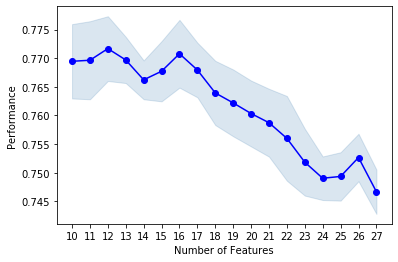

In [89]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
forest =RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100,class_weight=class_weights)
cv = StratifiedKFold(random_state=42,n_splits=5,shuffle=True) 
seqbacksel_rf = SFS(forest, k_features = (10, 27), forward = False, floating = False, scoring = my_score, cv = cv, n_jobs = -1)
seqbacksel_rf = seqbacksel_rf.fit(train_new[learn_cols],train_new[target_col])
print('best combination (ACC: %.3f): %s\n' % (seqbacksel_rf.k_score_, seqbacksel_rf.k_feature_idx_))
print('all subsets:\n', seqbacksel_rf.subsets_)
plot_sfs(seqbacksel_rf.get_metric_dict(), kind='std_err');

without weights n_estimators=100 cv=5 stratified
best combination (ACC: 0.786): (0, 2, 3, 5, 7, 9, 10, 12, 13, 15, 20, 21, 22, 23, 24, 25)
16: {'feature_idx': (0, 2, 3, 5, 7, 9, 10, 12, 13, 15, 20, 21, 22, 23, 24, 25), 'cv_scores': array([0.78489218, 0.77241208, 0.79910951, 0.80839646, 0.76576588]), 'avg_score': 0.7861152222222222, 'feature_names': ('Elevation', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points', 'wild_cat', 'stone_cat', 'Hyd_2_Fire', 'Fire_2_Road', 'Sin_Aspect', 'soil_wild_cat', 'if_below', 'Rock_cat', 'if_Leighcan', 'if_Cryaquolls', 'if_Catamount')},



with weights n_estimators=100 cv=5 stratified
best combination (ACC: 0.772): (0, 2, 3, 7, 8, 9, 10, 11, 13, 15, 20, 23)

12: {'feature_idx': (0, 2, 3, 7, 8, 9, 10, 11, 13, 15, 20, 23), 'cv_scores': array([0.76798641, 0.75993641, 0.78490269, 0.78522056, 0.76029025]), 'avg_score': 0.771667263888889, 'feature_names': ('Elevation', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'soil_cat', 'wild_cat', 'stone_cat', 'Hyd_2_Road', 'Fire_2_Road', 'Sin_Aspect', 'soil_wild_cat', 'if_Leighcan')},

So under question are 8, 11 that is soil_cat and 'Hyd_2_Road'; I will add soil_cat to final version

In [132]:
learn_cols_tuned=['Elevation','soil_cat', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_Noon', 'Horizontal_Distance_To_Fire_Points', 'wild_cat', 'stone_cat', 'Hyd_2_Fire', 'Fire_2_Road', 'Sin_Aspect', 'soil_wild_cat', 'if_below', 'Rock_cat', 'if_Leighcan', 'if_Cryaquolls', 'if_Catamount']

#### Next I check the weights of each feature in models; 

I start with all features

In [100]:
import eli5
from eli5.sklearn import PermutationImportance

In [105]:
#first I split the data
X_train, X_val, Y_train, Y_val = train_test_split(train_new[learn_cols], train_new[target_col], stratify=train_new[target_col],  test_size=0.2,random_state=42)

In [106]:
forest_model=RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100)
forest_model.fit(X_train,Y_train)
perm = PermutationImportance(forest_model, random_state=1).fit(X_val, Y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.3101 ± 0.0095,Elevation
0.0560 ± 0.0058,wild_cat
0.0444 ± 0.0033,Horizontal_Distance_To_Roadways
0.0307 ± 0.0077,Horizontal_Distance_To_Fire_Points
0.0159 ± 0.0031,Fire_2_Road
0.0104 ± 0.0032,Hyd_2_Road
0.0103 ± 0.0022,soil_wild_cat
0.0073 ± 0.0020,Hyd_2_Fire
0.0068 ± 0.0016,Hillshade_9am
0.0063 ± 0.0020,Vertical_Distance_To_Hydrology


In [107]:
print("special acc is: ",bal_acc(Y_val,forest_model.predict(X_val.values),weights=list_weight))

special acc is:  (0.749985, 0.869047619047619)


#### Now only good features

In [169]:
#first I split the data
X_train, X_val, Y_train, Y_val = train_test_split(train_new[learn_cols_tuned], train_new[target_col], stratify=train_new[target_col],  test_size=0.2,random_state=42)

In [130]:
forest_model=RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100)
forest_model.fit(X_train,Y_train)
perm = PermutationImportance(forest_model, random_state=1).fit(X_val, Y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
0.3956 ± 0.0156,Elevation
0.0972 ± 0.0064,wild_cat
0.0821 ± 0.0087,Horizontal_Distance_To_Roadways
0.0561 ± 0.0029,Horizontal_Distance_To_Fire_Points
0.0452 ± 0.0106,Hyd_2_Fire
0.0386 ± 0.0064,Fire_2_Road
0.0331 ± 0.0068,Hillshade_Noon
0.0310 ± 0.0060,Sin_Aspect
0.0220 ± 0.0053,Vertical_Distance_To_Hydrology
0.0175 ± 0.0039,soil_cat


In [131]:
print("special acc is: ",bal_acc(Y_val,forest_model.predict(X_val.values),weights=list_weight))

special acc is:  (0.7720307175925926, 0.8792989417989417)


Result: strange but if below seems to have zero weight but boost the results. So I will keep all the features that came from the first fitting

#### Encodings?

Eventhough the code for encodigns was made up it seems not to help in any way;
'soil_cat', 'soil_wild_cat' have lot's of labels and I will try to encode them and check if they will help

Now check if encoding will help by adding encodings and checkign their importance

In [218]:
#first I split the data
X_train, X_val, Y_train, Y_val = train_test_split(train_new[learn_cols_tuned], train_new[target_col], stratify=train_new[target_col],  test_size=0.2,random_state=42)

In [219]:
X_train_2,X_val_2=full_enc_6(pd.concat([X_train,Y_train],axis=1),['soil_cat','soil_wild_cat'],target_col,100,3,[1,2],df_test=X_val)

In [220]:
X_train_2=X_train_2.drop(columns=target_col)

In [221]:
forest_model=RandomForestClassifier(bootstrap = False,verbose=0,random_state=42,n_estimators=100)
forest_model.fit(X_train_2,Y_train)
perm = PermutationImportance(forest_model, random_state=1).fit(X_val_2, Y_val)
eli5.show_weights(perm, feature_names = X_val_2.columns.tolist())

Weight,Feature
0.3247 ± 0.0193,Elevation
0.0643 ± 0.0047,Horizontal_Distance_To_Roadways
0.0504 ± 0.0112,Horizontal_Distance_To_Fire_Points
0.0394 ± 0.0037,Hyd_2_Fire
0.0333 ± 0.0071,Fire_2_Road
0.0304 ± 0.0033,Hillshade_Noon
0.0298 ± 0.0033,Sin_Aspect
0.0209 ± 0.0062,Vertical_Distance_To_Hydrology
0.0148 ± 0.0037,wild_cat
0.0104 ± 0.0044,soil_wild_cat_enc_1


In [222]:
print("special acc is: ",bal_acc(Y_val,forest_model.predict(X_val_2.values),weights=list_weight))

special acc is:  (0.7626302546296296, 0.8746693121693122)


Tried different combinations of encodings but they seem to fail so I will skip it for RF; So skip encoding entirely;

### HyperParameter Tuning

I will use bayesian optimization to find optimal values for n_estimators, max_depth and max_features;

First I will do quite a lot on simple train test split and some more in cross validation; metric is my_score; 

https://github.com/fmfn/BayesianOptimization

Paramters:
- n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
- init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
- verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
 
 https://github.com/fmfn/BayesianOptimization/blob/master/examples/basic-tour.ipynb
 
 When dealing with functions with discrete parameters,or particularly erratic target space it might be beneficial to increase the value of the alpha parameter. This parameters controls how much noise the GP can handle, so increase it whenever you think that extra flexibility is needed.

In [223]:
#first I split the data
X_train, X_val, Y_train, Y_val = train_test_split(train_new[learn_cols_tuned], train_new[target_col], stratify=train_new[target_col],  test_size=0.2,random_state=42)

In [224]:
def Bayes_RandomTrees2(n_estimators, max_depth,max_features):
    
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    assert type(n_estimators) == int
    assert type(max_depth) == int

    etc =RandomForestClassifier(n_estimators = n_estimators,max_features = max_features,bootstrap = False,max_depth=max_depth,verbose=0,n_jobs=-1,random_state=42)
    #etc =RandomForestClassifier(n_estimators = n_estimators,max_features = max_features,bootstrap = False,max_depth=max_depth,verbose=0,n_jobs=-1,class_weight=class_weights,random_state=42)
    etc.fit(X_train.values, Y_train.values)
    
    score = bal_acc2(Y_val.values, etc.predict(X_val.values))
    
    return score

In [225]:
params = {'n_estimators' : (40, 600),
          'max_depth' : (10, 150),
          'max_features' : (.2,0.7)} 

RandomTreeBO = BayesianOptimization(Bayes_RandomTrees2, params, random_state = 42)

print(RandomTreeBO.space.keys)


['max_depth', 'max_features', 'n_estimators']


In [226]:
init_points = 50
n_iter = 50

In [227]:
RandomTreeBO.maximize(init_points = init_points,  n_iter = n_iter,   acq = 'ucb',    xi = 0.0,        alpha = 1e-6)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.7505   |  62.44    |  0.6754   |  449.9    |
|  2        |  0.7649   |  93.81    |  0.278    |  127.4    |
|  3        |  0.7474   |  18.13    |  0.6331   |  376.6    |
|  4        |  0.767    |  109.1    |  0.2103   |  583.1    |
|  5        |  0.7612   |  126.5    |  0.3062   |  141.8    |
|  6        |  0.763    |  35.68    |  0.3521   |  333.9    |
|  7        |  0.7636   |  70.47    |  0.3456   |  382.6    |
|  8        |  0.7582   |  29.53    |  0.3461   |  245.2    |
|  9        |  0.7478   |  73.85    |  0.5926   |  151.8    |
|  10       |  0.7488   |  81.99    |  0.4962   |  66.01    |
|  11       |  0.7664   |  95.06    |  0.2853   |  76.43    |
|  12       |  0.7483   |  142.8    |  0.6828   |  492.7    |
|  13       |  0.7609   |  52.65    |  0.2488   |  423.2    |
|  14       |  0.7658   |  71.62    |  0.261    |  317.3    |
|  15   

|  80       |  0.7605   |  136.7    |  0.2264   |  420.1    |
|  81       |  0.7617   |  48.57    |  0.2079   |  99.0     |
|  82       |  0.7661   |  94.67    |  0.2049   |  366.1    |
|  83       |  0.7616   |  43.72    |  0.2085   |  266.7    |
|  84       |  0.6834   |  10.59    |  0.2417   |  310.7    |
|  85       |  0.7621   |  95.79    |  0.2378   |  242.7    |
|  86       |  0.7616   |  94.7     |  0.2127   |  416.6    |
|  87       |  0.7672   |  102.4    |  0.2009   |  151.8    |
|  88       |  0.7628   |  149.6    |  0.2352   |  262.9    |
|  89       |  0.761    |  92.21    |  0.2076   |  40.42    |
|  90       |  0.7626   |  47.48    |  0.2473   |  316.5    |
|  91       |  0.7636   |  34.15    |  0.2033   |  162.8    |
|  92       |  0.7673   |  96.13    |  0.2108   |  273.9    |
|  93       |  0.7659   |  92.57    |  0.2138   |  562.0    |
|  94       |  0.7658   |  41.74    |  0.2295   |  66.06    |
|  95       |  0.7706   |  149.9    |  0.2284   |  369.0    |
|  96   

In [228]:
print(RandomTreeBO.max)

{'target': 0.770591388888889, 'params': {'max_depth': 149.94551890346608, 'max_features': 0.22844110488296226, 'n_estimators': 369.02506331242887}}


Result:
- the optimal number of max_features is around 0.21 - that is close to  number 'auto'
- there is no pattern in n_estimators and max_depth - should try one more time with 

{'target': 0.770591388888889, 'params': {'max_depth': 149.94551890346608, 'max_features': 0.22844110488296226, 'n_estimators': 369.02506331242887}}

#### Now only 2 parameters and cross validation

In [230]:
def Bayes_RandomTrees(n_estimators, max_depth):#,max_features):
    
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    assert type(n_estimators) == int
    assert type(max_depth) == int
    
    #etc =RandomForestClassifier(n_estimators = n_estimators,max_features = 'auto',bootstrap = False,max_depth=max_depth,verbose=0,random_state=42,class_weight=class_weights)
    etc =RandomForestClassifier(n_estimators = n_estimators,max_features = 'auto',bootstrap = False,max_depth=max_depth,verbose=0,random_state=42)
    cv = StratifiedKFold(random_state=42,n_splits=5,shuffle=True) 
    CrossValidationscores = cross_val_score(etc, train_new[learn_cols_tuned], train_new[target_col], cv=cv, scoring = my_score,n_jobs=-1)
    
    score = np.mean(CrossValidationscores)
    
    return score

In [231]:
params = {'n_estimators' : (50, 500),
          'max_depth' : (30, 150)} 

RandomTreeBO_2 = BayesianOptimization(Bayes_RandomTrees, params, random_state = 42)

print(RandomTreeBO_2.space.keys)



['max_depth', 'n_estimators']


In [232]:
init_points = 50
n_iter = 50

In [233]:
RandomTreeBO_2.maximize(init_points = init_points,  n_iter = n_iter,   acq = 'ucb',    xi = 0.0,        alpha = 1e-6)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.7854   |  74.94    |  477.8    |
|  2        |  0.7835   |  117.8    |  319.4    |
|  3        |  0.7856   |  48.72    |  120.2    |
|  4        |  0.7856   |  36.97    |  439.8    |
|  5        |  0.7838   |  102.1    |  368.6    |
|  6        |  0.7842   |  32.47    |  486.5    |
|  7        |  0.7845   |  129.9    |  145.6    |
|  8        |  0.7846   |  51.82    |  132.5    |
|  9        |  0.7849   |  66.51    |  286.1    |
|  10       |  0.7861   |  81.83    |  181.1    |
|  11       |  0.7866   |  103.4    |  112.8    |
|  12       |  0.7828   |  65.06    |  214.9    |
|  13       |  0.7842   |  84.73    |  403.3    |
|  14       |  0.7849   |  53.96    |  281.4    |
|  15       |  0.7868   |  101.1    |  70.9     |
|  16       |  0.7858   |  102.9    |  126.7    |
|  17       |  0.7854   |  37.81    |  477.0    |
|  18       |  0.7848   |  145.9    |  413.8    |


|  100      |  0.7882   |  86.15    |  95.9     |


In [234]:
print(RandomTreeBO_2.max)

{'target': 0.7882563287037037, 'params': {'max_depth': 87.04860802984732, 'n_estimators': 96.76128131855384}}


Result:
It seems that the depth and n_estimators are not so important for score - the volatility of optimal values is huge; 

'target': 0.7882563287037037, 'params': {'max_depth': 87.04860802984732, 'n_estimators': 96.76128131855384}

So it seems that stable way would be to use depth 87 and n_estimators=100 (default)

### Making predictions for KFOld

Now I will make 5 Kfold fitting where I use 1 fold as validaiotn and 4 as train; I will save the predictions for each validation for further fitting;

In [245]:
def train_forest(data_train,data_val,learn_cols,target_col):
    forest_model=RandomForestClassifier(n_estimators = 100,max_features = 'auto',bootstrap = False,max_depth=87,verbose=0)
    #forest_model=RandomForestClassifier(n_estimators = 100,max_features = 'auto',bootstrap = False,max_depth=87,verbose=0,class_weight=class_weights)
    forest_model.fit(data_train[learn_cols].values, data_train[target_col].values)
    forest_model_prob=forest_model.predict_proba(data_val[learn_cols].values)
    return forest_model_prob

In [246]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
skf.get_n_splits(train_new)
result=pd.DataFrame(np.zeros([train_new.shape[0],7]))

In [247]:
i=0
for train_index, test_index in skf.split(train_new[learn_cols_tuned],train_new[target_col]):
    data_train=train_new.iloc[train_index,:].copy()
    data_val=train_new.iloc[test_index,:].copy()
    result.iloc[test_index,:]=train_forest(data_train,data_val,learn_cols_tuned,target_col)
    print('stage done ',i)
    i+=1

stage done  0
stage done  1
stage done  2
stage done  3
stage done  4


In [248]:
predic=np.argmax(result.values,1)+1

In [249]:
#the accuracy of validation
print("acc is: ",accuracy_score(train_new[target_col].values,predic))
print("special acc is: ",bal_acc(train_new[target_col].values,predic,weights=list_weight))

acc is:  0.8853174603174603
special acc is:  (0.786329462962963, 0.8853174603174603)


Result:
acc is:  0.8853174603174603
special acc is:  (0.786329462962963, 0.8853174603174603)

Adding the weights only worsen the result;

In [250]:
confusion_matrix(train_new[target_col].values,predic)

array([[1715,  309,    2,    0,   27,    3,  104],
       [ 316, 1618,   44,    0,  124,   45,   13],
       [   0,   14, 1859,   82,   17,  188,    0],
       [   0,    0,   44, 2091,    0,   25,    0],
       [   4,   43,   27,    0, 2070,   16,    0],
       [   2,   11,  160,   46,    8, 1933,    0],
       [  54,    6,    0,    0,    0,    0, 2100]], dtype=int64)

In [251]:
#saving
result.to_csv('forest_train_prob.csv')

### predictions for test
#### fitting on full data

In [252]:
forest_full=RandomForestClassifier(n_estimators = 100,max_features = 'auto',bootstrap = False,max_depth=87,verbose=0)
forest_full.fit(train_new[learn_cols_tuned].values, train_new[target_col].values)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=87, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### making the predictions on test

In [253]:
test=pd.read_csv(os.path.join(os.getcwd(),'test.csv.zip'))
test_new=add_cat(test,soil_type,wild_type,soil_names,hill_feat)

In [67]:
#adding encodings as mean encodings 
#enc_cols=[x for x in train_new.columns if 'enc' in x]
#for enc_col in enc_cols:
#    test_new[enc_col]=test_new[enc_col[:-6]].map(train_new.groupby(enc_col[:-6])[enc_col].mean())
#for target in list(train_new[target_col].unique()[:-1]):
#    temp_cols_2=[x for x in test_new.columns if 'enc_{}'.format(target) in x]
#    if (len(temp_cols_2)>0):
#        test_new[temp_cols_2]=test_new[temp_cols_2].fillna(np.mean((train_new[target_col]==target)*1))

In [254]:
forest_pred_test=pd.DataFrame(forest_full.predict_proba(test_new[learn_cols_tuned]),index=test.Id.values)

In [255]:
forest_pred_test.to_csv('forest_test_prob.csv')

Saving for submission

In [256]:
sub=pd.DataFrame(test.Id.values,columns=['ID'])
sub['Cover_Type']=(np.argmax(forest_pred_test.values,1)+1).astype('int64')
sub.to_csv('FR_tuned.csv',index=False)

score of this model is 0.79367